# Import necessary packages

In [1]:
using DifferentialEquations, Graphs
using YardSale
using Plots, LaTeXStrings, ColorSchemes

# Description of the model

Here we're going to use the functionalities of the ODE solver implemented in `YardSale.jl`.
These are simple functions that wrap the `DifferentialEquations.jl` package to solve the
ODE systems we're interested in. By wrapping, we are allowed to explore efficiently the
parameters space. 

The models we're going to explore belong to a wider class of models called _Asset Exchange Models_. These are 
models inspired in the statistical physics of interacting particles. The main idea is that
agents exchange assets in a network, just like particles exchange energy in a physical system.
The dynamics of the system is given by the exchange rules, which usually involve binary
transactions. For a review of these models, see for example _Greenberg, M., Gao, H.O. Twenty-five years of random asset exchange modeling. Eur. Phys. J. B 97, 69 (2024) [DOI](https://doi.org/10.1140/epjb/s10051-024-00695-3)._

Here, we're studying specifically and ODE approximation of one of these models, called the _"Extended Yard-Sale Model"_ (EYSM),
published in _Boghosian et al. (2017). Physica A, 476, 15-42 [DOI](https://doi.org/10.1016/j.physa.2017.01.071)._ 
For details on the derivation of the equations please refer to our original paper.

Given a network $a$, the model is defined by the following set of ODEs:
$$
\begin{equation*}
\dot{x}_i = \frac{T}{N} \bigg(-\beta_i x_i+\frac{1}{N}\sum_j \beta_j x_j\bigg) + \sum_j\kappa_{ij}(x_i-x_j)\min(x_i,x_j)
\tag{1} 
\end{equation*}

$$

where $x_i$ represents the (expected) relative wealth of agent $i$, and $T$ represents the temperature.
The parameters $\beta_i$ and $\kappa_{ij}$ are parameters which contain information about the network structure of $a$,
and the way in which agents get taxed and interact with each other, respectively.

As described in the original paper, the EYSM exhibits a second-order phase transition as a function of the temperature $T$ when the network is a complete graph. This transition is characterized by the emergence of an oligarchy at low temperatures, where a few agents accumulate most of the wealth. At high temperatures, the wealth is more evenly distributed among the agents. The transition is characterized by the order parameter $x_1$ (the wealth of the richest agent) as a function of the temperature $T$. In the thermodynamic limit, the order parameter behaves as 
$$
\begin{equation*}
x_1(T) = \begin{cases}
1 - T & \text{if } T \leq 1 \\ 
0 & \text{if } T > 1
\end{cases}
\tag{2}
\end{equation*}
$$

In this notebook, we're going to reproduce the phase transition of the EYSM in a complete graph, using the implementation of the ODE solver in `YardSale.jl`.

# 1. A first look at the model

Let's study the time evolution of the wealth distribution in the original EYSM. We'll set 
a system of few agents, and we'll plot the wealth of all agents as a function of time.

In [2]:
# Number of nodes
N = 16
# A complete graph with N nodes (Graphs.jl)
g = complete_graph(N)
# Interaction and taxation modes
interaction_mode = "A"
taxation_mode = "A"
# Temperature
T = 1.0
# Time span
tspan = (0.0, 30000)
dt = 10
# Seed
seed = 42
# Initial conditions
initial_conditions = "noisy" # Defaul, but you can also use "random", "custom", or "uniform"
;

In [3]:
# Solve the system
sol = solve_ode_net(
    g,
    tspan,
    interaction_mode,
    taxation_mode,
    T,
    seed;
    integrator = Tsit5(),
    initial_conditions = initial_conditions,
    saveat = dt
)
;

In [4]:
# Get the time series of the state variables, sorted by final state
x_t = hcat(sol.u...)'[:, sortperm(sol.u[end])]

3001×16 Matrix{Float64}:
 0.0611785  0.0615817  0.0619628  …  0.0630102  0.0630252  0.0634045
 0.0611742  0.0615783  0.0619606     0.0630128  0.0630278  0.0634091
 0.0611699  0.0615749  0.0619584     0.0630154  0.0630305  0.0634137
 0.0611656  0.0615715  0.0619563     0.063018   0.0630332  0.0634184
 0.0611612  0.0615681  0.0619541     0.0630206  0.0630359  0.063423
 0.0611569  0.0615646  0.0619519  …  0.0630232  0.0630386  0.0634277
 0.0611526  0.0615612  0.0619497     0.0630258  0.0630413  0.0634324
 0.0611482  0.0615577  0.0619475     0.0630285  0.063044   0.0634371
 0.0611438  0.0615543  0.0619452     0.0630311  0.0630467  0.0634418
 0.0611395  0.0615508  0.061943      0.0630338  0.0630495  0.0634466
 0.0611351  0.0615473  0.0619408  …  0.0630365  0.0630522  0.0634513
 0.0611307  0.0615438  0.0619385     0.0630392  0.063055   0.0634561
 0.0611263  0.0615403  0.0619363     0.0630419  0.0630578  0.063461
 ⋮                                ⋱                        ⋮
 0.0585937  0.05859

In [5]:
# Rescale the time units to MC steps
t_mcs = rescale_t(sol.t,N)
;

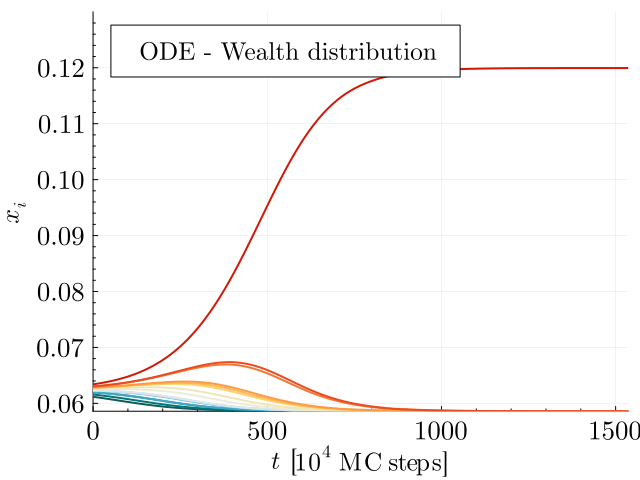

In [6]:
# Make the paper plot
p = plot(
    ylabel = L"x_i",
    xlabel = L"t"*" ["*L"10^{4}\;\mathrm{MC\;steps}]",
    fontfamily = "Computer Modern",
    legend_title = "ODE - Wealth distribution",
    xguidefontsize = 17,
    yguidefontsize = 17,
    legendfontsize = 15,
    legendtitlefontsize = 16,
    xtickfontsize = 17,
    ytickfontsize = 17,
    palette = :tol_nightfall,
    size=(640,480),
    fmt=:png,
    ylims = (:auto, 0.13),
    xlims = (0,:auto),
    minorticks = true
)

for i in 1:N
    plot!(t_mcs ./ 1e4, x_t[:, i], label = "", lw = 2)
end

display(p)

# 2.Wealth of the richest agent as a function of the temperature (order parameter)

Next, we'd like to see the phase transition looking at the plot of the wealth of the richest agent $x_1$ as a function of the temperature $T$. We must run the simulation at different temperatures, record the wealth of the richest agent at the end of the simulations. We'll then plot the wealth of the richest agent as a function of the temperature. Notice that the simulations have an transient period, so we must run the simulations for a long enough time to ensure that the system has reached the steady state. For our purposes, a $t_{\text{max}} = 10^7$ should be enough. In any case, as we're not interested in intermediate times, we'll use a different solver, provided by the `DifferentialEquations.jl` package, which can search for the steady state of the system. That is what the `solve_ode_net_SS` function does.

We must increase the default tolerance of the integrator, because the system has critical behavior near the phase transition. We'll set the tolerante to $10^{-15}$.

In [7]:
# The system has to be big enough to discard finite size effects
N = 128
g = complete_graph(N)
# Interacion and taxation modes
interaction_mode = "A"
taxation_mode = "B"
# Time span
tspan = (0.0, 1e7)
# Different temperatures
temperatures = 0.0:0.05:2.0
# Seed
seed = 42

42

In [8]:
# Run simulations
x1_T = zeros(length(temperatures))
# Solve the system for different temperatures
for (i,T) in enumerate(temperatures)
    sol = solve_ode_net_SS(
        g,
        interaction_mode,
        taxation_mode,
        T,
        seed;
        integrator = Tsit5(),
        initial_conditions = initial_conditions,
        reltol=1e-15,
        abstol=1e-15
    )
    x1_T[i] = maximum(sol.u)
end

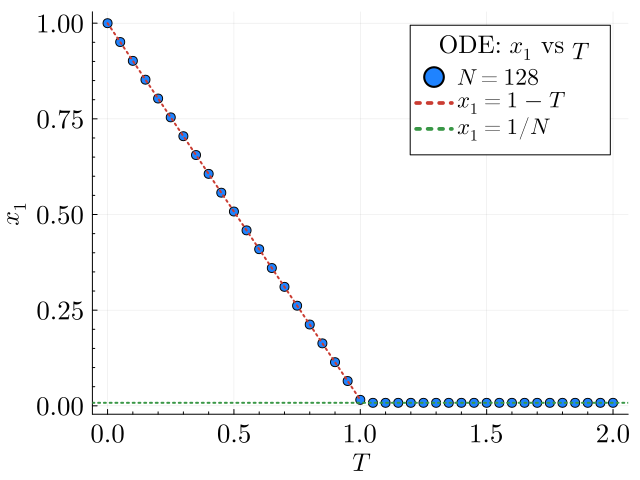

In [9]:
p2 = plot(
    ylabel = L"x_1",
    xlabel = L"T",
    fontfamily = "Computer Modern",
    legend_title = "ODE: " * L"x_1" * " vs " * L"T",
    xguidefontsize = 17,
    yguidefontsize = 17,
    legendfontsize = 15,
    legendtitlefontsize = 16,
    xtickfontsize = 17,
    ytickfontsize = 17,
    palette = :julia,
    size=(640,480),
    fmt=:png,
    minorticks = true
)

p = scatter!(
    p2,
    temperatures,
    x1_T,
    label = L"N="*"$N",
    ms = 5,
    color = 1
    )

p2 = plot!(p2,temperatures[1:21], x1_T[1:21], label=L"x_1 = 1 - T", lw = 2,ls=:dot,color=2)
p2 = hline!(p2,[1/N],label=L"x_1 = 1/N",lw=2,ls=:dot,color=3)